In [66]:
import torch
from torch import nn, optim
from torch.autograd import Variable


import numpy as np
import matplotlib.pyplot as plt

In [67]:
# create some data
np.random.seed(2019)
n, p = 2000, 10
x_train = np.random.rand(n, p).astype(np.float32)
w_true = np.random.rand(p, 1).astype(np.float32)

y_train = np.matmul(x_train, w_true)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

In [68]:
# create a model
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.w = torch.nn.Parameter(torch.randn(p, 1, requires_grad=True))
        self.b = torch.nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        out = torch.mm(x, self.w) + self.b
        return out
    
model = LinearRegression()

In [69]:
# define loss function
def customize_loss(y_hat, y):
    # define mean squared error (mse) loss
    # y.numel is the number of elements in y; y can be a vector or 2d, 3d tensor.
    loss = (y-y_hat).pow(2).sum()/y.numel()
    return loss

def calculate_norm(model, lambda1=1e-3, lambda2=1e-3):
    # no penaly on the bias term, so the bias term is excluded
    weights = torch.cat([p.view(-1) for p  in model.parameters() if p.numel()>1])
    l1 = lambda1 * torch.norm(weights, 1)
    l2 = lambda2 * torch.norm(weights, 2)
    return l1 + l2


In [70]:
# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# set the learning rate after you create an optimizer
# for g in optimizer.param_groups:
#     g['lr'] = 1e-5

In [71]:
# the training three steps: put the data in Variable, do forward pass, and backward pass;
# the backward pass include three steps: reset the gradient before doing backward, calcuate gradient; update the weights.
num_epochs = 3000
for epoch in range(num_epochs):
    inputs = Variable(x_train)
    target = Variable(y_train)

    # forward
    y_hat = model(inputs)
    loss = customize_loss(y_hat, target)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # always clip the weights to the range of zero and one
    w = model.w.data
    w.sub_(torch.min(w)).div_(torch.max(w) - torch.min(w))
    # set the weight to be always positive
    w *= torch.sign(w)

    if (epoch+1) % 200 == 0:
        print('Epoch[{}/{}], loss: {:.6f}' .format(epoch+1, num_epochs, loss.data))

# set the model in evaludation model. This does not make difference for LR
model.eval()
y_hat = model(Variable(x_train))
y_hat = y_hat.data.numpy()


Epoch[200/3000], loss: 0.231214
Epoch[400/3000], loss: 0.151679
Epoch[600/3000], loss: 0.068189
Epoch[800/3000], loss: 0.033528
Epoch[1000/3000], loss: 0.023721
Epoch[1200/3000], loss: 0.019109
Epoch[1400/3000], loss: 0.014253
Epoch[1600/3000], loss: 0.012319
Epoch[1800/3000], loss: 0.011819
Epoch[2000/3000], loss: 0.011666
Epoch[2200/3000], loss: 0.011579
Epoch[2400/3000], loss: 0.011491
Epoch[2600/3000], loss: 0.011389
Epoch[2800/3000], loss: 0.011268
Epoch[3000/3000], loss: 0.011125


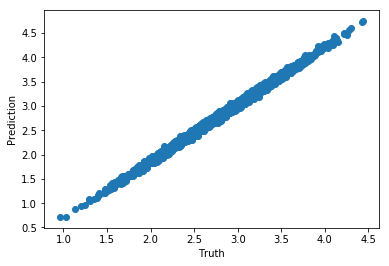

In [72]:
# visualize y_hat vs y_true
plt.scatter(y_train[:,0], y_hat[:,0])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.show()

In [73]:
# if the learned weights are not close the true weights at all, train more epoches.
print("w_true:", w_true)
model.state_dict()

w_true: [[0.5374348 ]
 [0.40696847]
 [0.84283584]
 [0.31304854]
 [0.09451906]
 [0.47716364]
 [0.6906084 ]
 [0.72971416]
 [0.69899505]
 [0.7572563 ]]


OrderedDict([('w', tensor([[0.6005],
                      [0.4300],
                      [1.0000],
                      [0.3147],
                      [0.0000],
                      [0.5380],
                      [0.8243],
                      [0.9113],
                      [0.8352],
                      [0.8882]])), ('b', tensor([-0.3975]))])

In [10]:
def save_weight_of_model(model, save_path="model.pth.tar"):
    checkpoint = {

       "weight" : model.state_dict(),
        "epoch": None
    }

    torch.save(checkpoint, save_path)

In [11]:
def load_weights_to_a_model(model, path="model.pth.tar"):
    checkpoint = torch.load("model.pth.tar")
    model.load_state_dict(checkpoint['weight'])
    return model

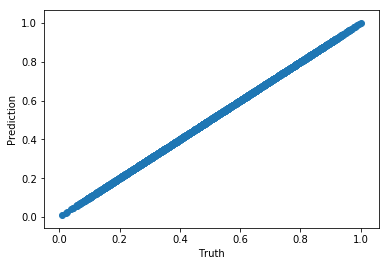

In [12]:
# save and load weight
save_weight_of_model(model)
model_load = LinearRegression()
model_load = load_weights_to_a_model(model_load, "model.pth.tar")
# make prediction using the loaded model
y_hat = model_load(Variable(x_train))
y_hat = y_hat.detach().numpy()

plt.scatter(y_train[:,0], y_hat[:,0])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.show()

In [13]:
# some possible bugs unique to pytorch.
# bug 1
np.random.seed(2019)
x_train = np.random.rand(n, p)
x_train = x_train.astype(np.float32)  # necessary
print("type of x:", x_train.dtype)
x_train = torch.from_numpy(x_train)
w = torch.randn(p, 1, requires_grad=True)
print("type of w:", w.dtype)
torch.matmul(x_train, w)[:3,]

type of x: float32
type of w: torch.float32


tensor([[0.9658],
        [0.9365],
        [1.2335]], grad_fn=<SliceBackward>)

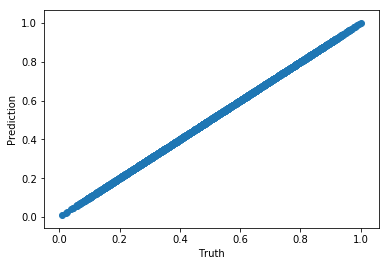

In [14]:
# mistake a tensor requiring grad as a numpy array
# bug 2
y_hat = model_load(Variable(x_train))
y_hat = y_hat.detach().numpy() # necessary

plt.scatter(y_train[:,0], y_hat[:,0])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.show()

In [15]:
# forget to zero out the gradient before doing backward pass
# bug 3
# optimizer.zero_grad()